In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transform
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report

In [ ]:
transform = transform.Compose([
    transform.Resize(224),
    transform.CenterCrop(224),
    transform.ToTensor(),
    transform.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [4]:
test_dir = '../../dataset/Test/'

test_dataset = ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

state_dict = torch.load('resnet50.pth', map_location=device)

model.load_state_dict(state_dict, strict=False)
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
correct = 0
total = 0
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%\n")

report = classification_report(all_labels, all_preds, target_names=test_dataset.classes, output_dict=True)

print(f"{'Class':<25} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Accuracy':<10}")
print("-" * 65)
for class_name in test_dataset.classes:
    cls_report = report[class_name]
    precision = cls_report['precision']
    recall = cls_report['recall']
    f1 = cls_report['f1-score']
    support = cls_report['support']
    acc = (recall * support) / support
    print(f"{class_name:<25} {precision:<10.2f} {recall:<10.2f} {f1:<10.2f} {acc*100:<10.2f}")

Test Accuracy: 91.10%

Class                     Precision  Recall     F1-Score   Accuracy  
-----------------------------------------------------------------
algal_spot                0.97       0.96       0.97       96.00     
brown-blight              0.96       0.86       0.91       85.92     
gray-blight               0.48       0.52       0.50       51.85     
healthy                   0.99       0.83       0.91       83.50     
helopeltis                0.84       0.97       0.90       97.50     
leaf-rust                 0.99       0.97       0.98       97.25     
red-rust                  0.57       1.00       0.73       100.00    
red-spider-infested       0.74       0.97       0.84       96.88     
red-spot                  0.89       0.94       0.91       93.50     
white-spot                0.92       0.92       0.92       92.31     


/tmp/ipykernel_475475/1683888910.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_names, y=metrics[i], palette='viridis')
/tmp/ipykernel_475475/1683888910.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_names, y=metrics[i], palette='viridis')
/tmp/ipykernel_475475/1683888910.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_names, y=metrics[i], palette='viridis')
/tmp/ipykernel_475475/1683888910.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be remov

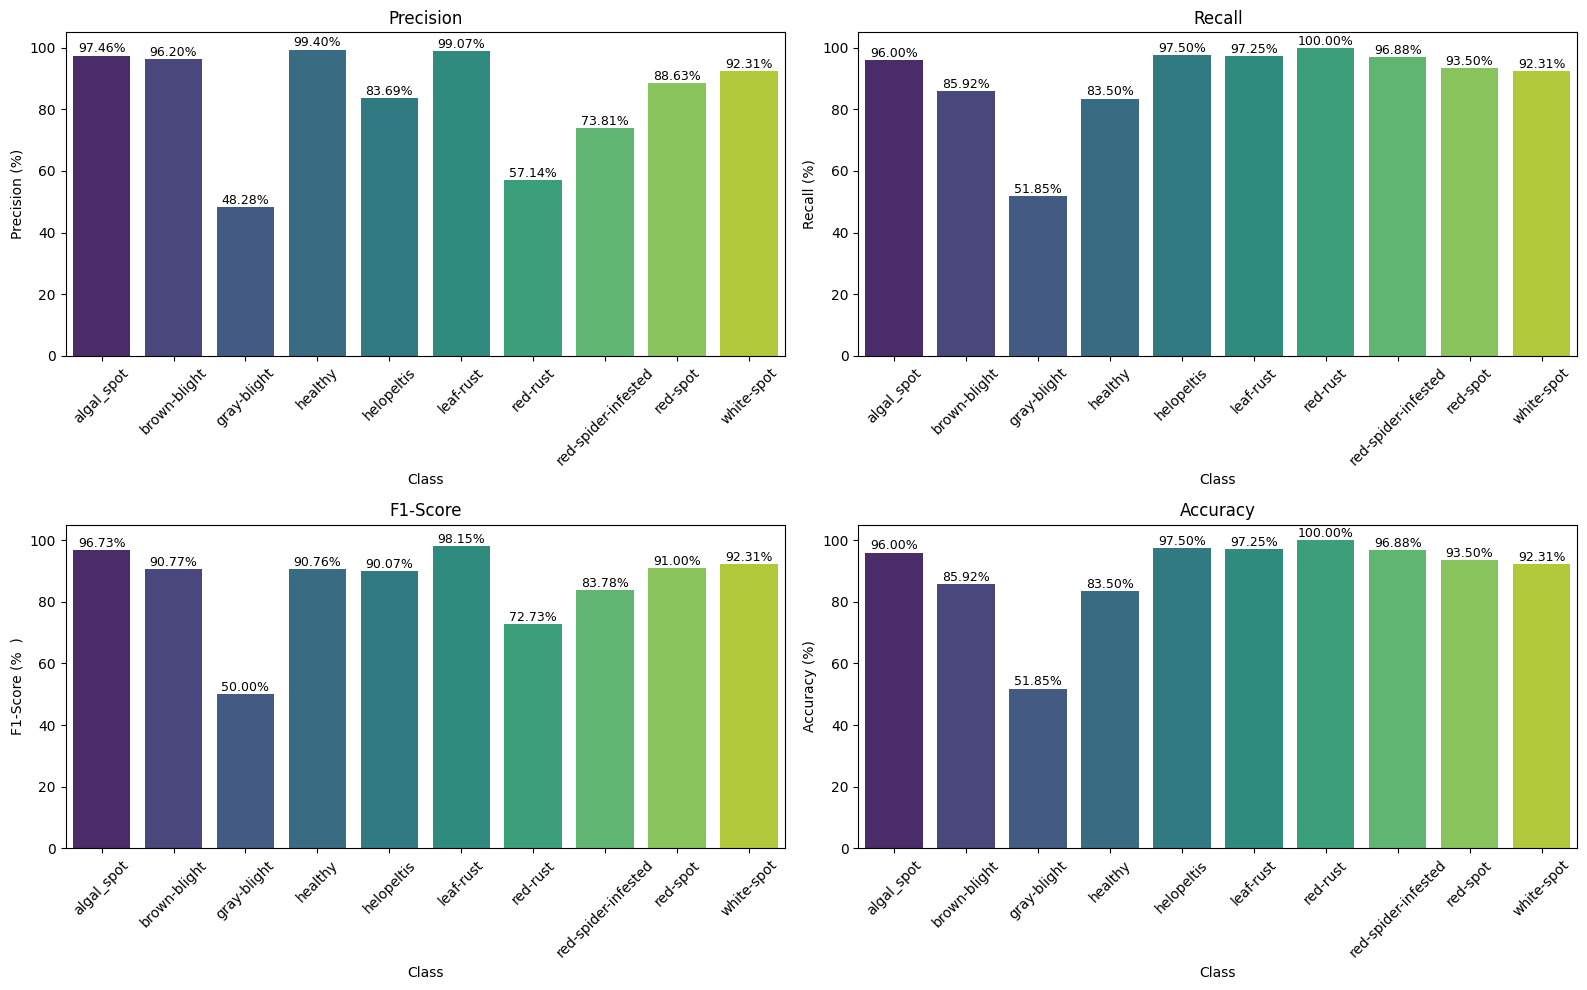

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# ambil metric masing-masing class
class_names = list(test_dataset.classes)
precisions = [report[cls]['precision'] * 100 for cls in class_names]
recalls = [report[cls]['recall'] * 100 for cls in class_names]
f1_scores = [report[cls]['f1-score'] * 100 for cls in class_names]
accuracies = [report[cls]['recall'] * 100 for cls in class_names]

# setup plot
plt.figure(figsize=(16, 10))
metrics = [precisions, recalls, f1_scores, accuracies]
titles = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
ylabels = ['Precision (%)', 'Recall (%)', 'F1-Score (%  )', 'Accuracy (%)']

for i in range(4):
    plt.subplot(2, 2, i+1)
    ax = sns.barplot(x=class_names, y=metrics[i], palette='viridis')
    plt.title(titles[i])
    plt.xlabel('Class')
    plt.ylabel(ylabels[i])    
    plt.ylim(0, 105)
    plt.xticks(rotation=45)
    
    for idx, p in enumerate(ax.patches):
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height + 1,
                f'{height:.2f}%', ha="center", fontsize=9)

plt.tight_layout()
plt.show()